In [2]:
import torch
import numpy as np
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm.notebook import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [3]:
TRAIN_DATA_PATH = "train"
TEST_DATA_PATH = "test"
training_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform = ToTensor())
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform = ToTensor())


In [6]:
test_data

Dataset ImageFolder
    Number of datapoints: 7178
    Root location: test
    StandardTransform
Transform: ToTensor()

In [3]:
batch_size = 256

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [4]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([256, 3, 48, 48])
Shape of y: torch.Size([256]) torch.int64


In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=64,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 128, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(128, 256, 3, 1, 1),     
            nn.ReLU(),                                      
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(256, 256, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        # for 6th layer
        self.conv5 = nn.Sequential(         
            nn.Conv2d(256, 128, 3, 1, 1),     
            nn.ReLU(), 
        )

        self.conv6 = nn.Sequential(         
            nn.Conv2d(128, 64, 3, 1, 1),     
            nn.ReLU(), 
        )

        # for 7th layer
        self.conv7 = nn.Sequential(         
            nn.Conv2d(64, 32, 3, 1, 1),     
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )
        self.dropout = nn.Dropout(0.3)
        # fully connected layer


        self.out = nn.Sequential(
            # change accordingly to number of layers
            nn.Linear(6*6*32,7),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.dropout(x)
        # flatten 
        x = x.view(x.size(0), -1)    

        output = self.out(x)
        return output

model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv7): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [32]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    pbar = tqdm(total=28709//256 + 1)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        pbar.update(1)
    pbar.close()


In [33]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [34]:
epochs = 64
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.946839  [    0/28709]
loss: 1.922046  [25600/28709]
Test Error: 
 Accuracy: 24.7%, Avg loss: 1.902490 

Epoch 2
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.874938  [    0/28709]
loss: 1.877800  [25600/28709]
Test Error: 
 Accuracy: 25.6%, Avg loss: 1.893554 

Epoch 3
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.871819  [    0/28709]
loss: 1.867665  [25600/28709]
Test Error: 
 Accuracy: 31.9%, Avg loss: 1.843666 

Epoch 4
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.843645  [    0/28709]
loss: 1.773158  [25600/28709]
Test Error: 
 Accuracy: 34.4%, Avg loss: 1.822343 

Epoch 5
-------------------------------


  0%|          | 0/113 [00:00<?, ?it/s]

loss: 1.807712  [    0/28709]


KeyboardInterrupt: 

In [77]:
torch.save(model.state_dict(), "model 7 layer 55 acc.pth")
print("Saved PyTorch Model State to modelcnn7.pth")


Saved PyTorch Model State to model.pth


In [78]:
model = CNN()
model.load_state_dict(torch.load("model 7 layer 55 acc.pth"))
model.to(device)



CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv7): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(

In [79]:
print('cnn')
test(test_dataloader, model, loss_fn)
# print('mlp')
# test(test_dataloader, model2, loss_fn)

cnn
Test Error: 
 Accuracy: 54.8%, Avg loss: 1.607474 



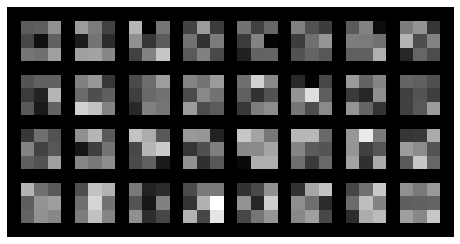

In [83]:
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


filter = model.conv7[0].cpu().weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()